## Time Series Forecasting Using Pyro

In [359]:
%reset -sf

In [360]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

### Lynx Dataset

In [361]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
lynx[:20]

,time,value
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
6,1826,2821
7,1827,3928
8,1828,5943
9,1829,4950
10,1830,2577


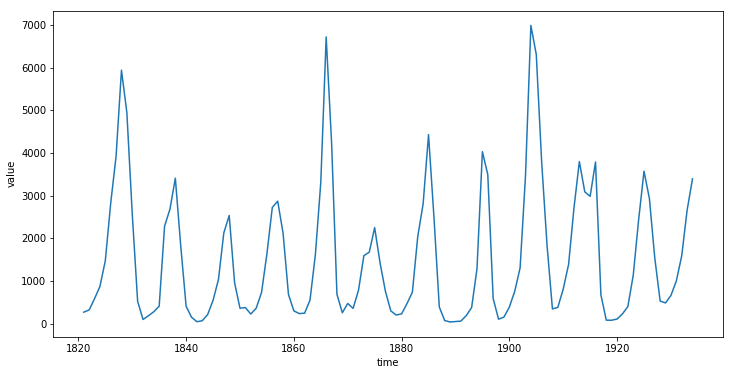

In [362]:
y = torch.tensor(lynx["value"].values, dtype=torch.float32)
y_train = y[:-30]
sns.lineplot('time', 'value', data=lynx);

### Model 1: Model based on SGT (Seasonal Global Trend)

In [363]:
def get_seasonality_lookup_idx(num_observed, S, idx):
    """
    Based on the the seasonality `S` and number of observed data points,
    return the index of the last observed data point that is one or more 
    seasons away from idx.
    
    e.g. 
    
    S=5, num_observed=11, idx=12, return -> 7
    S=5, num_observed=11, idx=18, return -> 8
    """
    if idx < S:
        return idx
    lookback = 1
    window_start = (int(idx / S) - lookback) * S
    lookup_idx = window_start + idx % S
    while lookup_idx >= num_observed:
        lookback = lookback + 1
        window_start = (int(idx / S) - lookback) * S
        lookup_idx = window_start + idx % S
    return lookup_idx

In [364]:
def model_sgt_1(y, seasonality, predict_ahead=0):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    alpha = pyro.sample('alpha', dist.Beta(1., 1.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.5))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma))

In [365]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})

svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())
S = 10  # Use seasonality of 10

for i in range(800):
    loss = svi.step(y_train, S)
    print('ELBO loss: {}'.format(loss))

ELBO loss: 847.3301115036011
ELBO loss: 1351.0053104162216
ELBO loss: 2339.345456659794
ELBO loss: 2063.035514175892
ELBO loss: 717.2194492816925
ELBO loss: 1445.5265382528305
ELBO loss: 731.9824587106705
ELBO loss: 971.6961234807968
ELBO loss: 1619.973911702633
ELBO loss: 849.0207360982895
ELBO loss: 971.9657754302025
ELBO loss: 752.6586678028107
ELBO loss: 942.8770286440849
ELBO loss: 821.42653632164
ELBO loss: 945.3909981250763
ELBO loss: 878.1958766579628
ELBO loss: 1714.7717652320862
ELBO loss: 1311.096826672554
ELBO loss: 786.8190876245499
ELBO loss: 2017.1543588638306
ELBO loss: 878.3644316792488
ELBO loss: 761.5019309520721
ELBO loss: 11338.798201441765
ELBO loss: 887.9829283952713
ELBO loss: 778.3184158205986
ELBO loss: 1080.014618396759
ELBO loss: 1123.3673126101494
ELBO loss: 743.0712413787842
ELBO loss: 941.9880165457726
ELBO loss: 926.5388600826263
ELBO loss: 759.6015964150429
ELBO loss: 769.8311672210693
ELBO loss: 718.7986904978752
ELBO loss: 940.8837686181068
ELBO loss:

ELBO loss: 705.5374327898026
ELBO loss: 701.6556584835052
ELBO loss: 707.4953520298004
ELBO loss: 705.2468447685242
ELBO loss: 710.0698081254959
ELBO loss: 705.7970300912857
ELBO loss: 703.5428369045258
ELBO loss: 706.1061091423035
ELBO loss: 711.382450401783
ELBO loss: 706.9614650011063
ELBO loss: 707.2442800998688
ELBO loss: 708.0915381908417
ELBO loss: 708.6776119470596
ELBO loss: 707.2911533713341
ELBO loss: 705.1879395246506
ELBO loss: 707.8817859888077
ELBO loss: 708.4004545211792
ELBO loss: 707.1066352128983
ELBO loss: 706.5095022916794
ELBO loss: 705.7766884565353
ELBO loss: 708.4712077975273
ELBO loss: 708.7350651025772
ELBO loss: 704.2673662304878
ELBO loss: 704.9958894252777
ELBO loss: 707.07357442379
ELBO loss: 708.501287817955
ELBO loss: 706.864263355732
ELBO loss: 707.480120241642
ELBO loss: 707.6644957065582
ELBO loss: 707.0005000829697
ELBO loss: 707.798923432827
ELBO loss: 708.866286277771
ELBO loss: 705.8812178969383
ELBO loss: 713.125883102417
ELBO loss: 718.47337043

ELBO loss: 705.0401811599731
ELBO loss: 710.5179750919342
ELBO loss: 709.3620694875717
ELBO loss: 708.4908577203751
ELBO loss: 710.8765032291412
ELBO loss: 704.7757133245468
ELBO loss: 710.3543990850449
ELBO loss: 709.3656475543976
ELBO loss: 707.3969799876213
ELBO loss: 706.3168026804924
ELBO loss: 707.2645681500435
ELBO loss: 705.9756363630295
ELBO loss: 706.6844547986984
ELBO loss: 705.877723813057
ELBO loss: 707.3454811573029
ELBO loss: 709.4593657255173
ELBO loss: 706.633246421814
ELBO loss: 705.7302144765854
ELBO loss: 704.904254078865
ELBO loss: 707.7899097800255
ELBO loss: 705.1458012461662
ELBO loss: 706.6044012308121
ELBO loss: 708.3322550058365
ELBO loss: 702.1651221513748
ELBO loss: 712.5734162330627
ELBO loss: 707.5200091600418
ELBO loss: 705.7993845939636
ELBO loss: 707.9896166324615
ELBO loss: 710.6172798871994
ELBO loss: 706.1570802330971
ELBO loss: 707.5684245824814
ELBO loss: 708.3556455373764
ELBO loss: 708.2030799388885
ELBO loss: 705.2173687815666
ELBO loss: 712.94

In [366]:
def predict(model, guide, y, *args, future_steps=30, num_samples=100):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(y, *args, predict_ahead=future_steps)
        model_trace = poutine.trace(poutine.replay(model, guide_trace)).get_trace(y, *args, 
                                                                                  predict_ahead=future_steps)
        preds.append(torch.cat([model_trace.nodes['y']['value'], model_trace.nodes['y_pred']['value']]))
        l.append(model_trace.nodes['l']['value'])
        s.append(model_trace.nodes['s']['value'])
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [367]:
num_samples = 500
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

In [368]:
res1 = lynx.copy()
res1['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res1 = res1.append(df, sort=True)
res1 = res1.astype({'time': 'int32'})

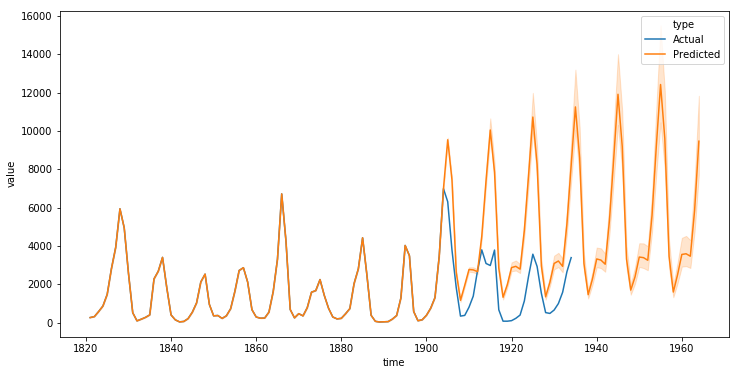

In [369]:
sns.lineplot('time', 'value', data=res1, hue='type');

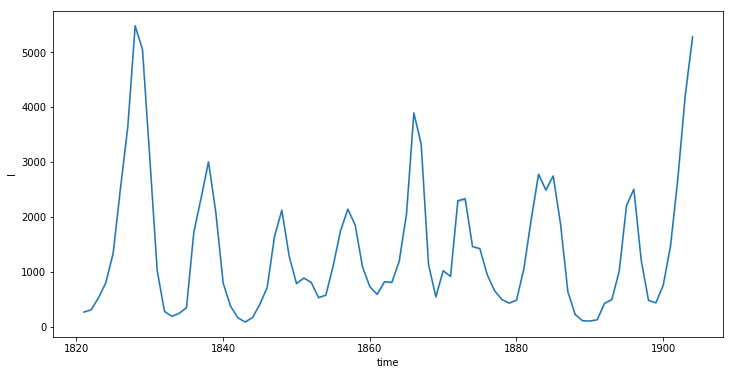

In [370]:
sns.lineplot('time', 'l', data=res1);

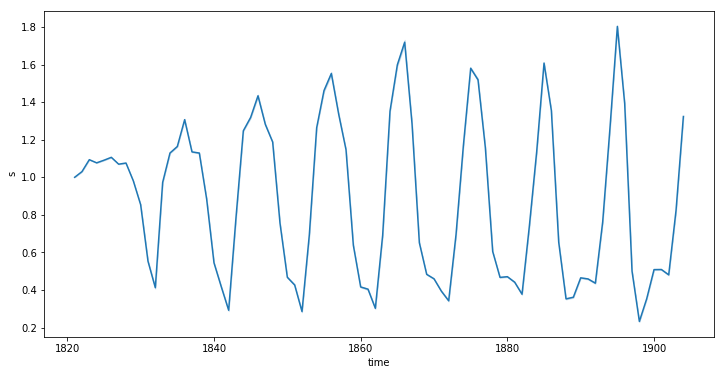

In [371]:
sns.lineplot('time', 's', data=res1);

### Model dual seasonality (use the higher S=38)

In [372]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_1)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_1, guide, opt, loss=Trace_ELBO())

for i in range(800):
    loss = svi.step(y_train, S)
    print('ELBO loss: {}'.format(loss))

ELBO loss: 1086.5868203639984
ELBO loss: 781.4128661751747
ELBO loss: 2303.622690677643
ELBO loss: 2749.6283029913902
ELBO loss: 1215.2689225673676
ELBO loss: 1340.1808253526688
ELBO loss: 1684.3805845975876
ELBO loss: 1012.6800701618195
ELBO loss: 1110.0104882717133
ELBO loss: 1593.7436453700066
ELBO loss: 1142.3642063736916
ELBO loss: 1098.691759467125
ELBO loss: 793.7920197248459
ELBO loss: 825.138152718544
ELBO loss: 2502.7926791906357
ELBO loss: 790.3193655014038
ELBO loss: 921.5242195129395
ELBO loss: 1714.5837831497192
ELBO loss: 751.9306378364563
ELBO loss: 755.1777874231339
ELBO loss: 910.6716312766075
ELBO loss: 962.4623205661774
ELBO loss: 766.5994482040405
ELBO loss: 934.0060024261475
ELBO loss: 724.8776047825813
ELBO loss: 817.1511752605438
ELBO loss: 843.904344201088
ELBO loss: 826.2188383340836
ELBO loss: 796.9891881942749
ELBO loss: 947.783468067646
ELBO loss: 792.5578259825706
ELBO loss: 725.4558824896812
ELBO loss: 719.1278604865074
ELBO loss: 725.8269040584564
ELBO l

ELBO loss: 726.2305171489716
ELBO loss: 736.4714879989624
ELBO loss: 753.6876567602158
ELBO loss: 717.8106332421303
ELBO loss: 732.6523687839508
ELBO loss: 725.9031790494919
ELBO loss: 734.1329119205475
ELBO loss: 721.4022397994995
ELBO loss: 732.0824346542358
ELBO loss: 725.3767668008804
ELBO loss: 722.4209852218628
ELBO loss: 729.2936000823975
ELBO loss: 721.1504096984863
ELBO loss: 721.6847653985023
ELBO loss: 723.2271005511284
ELBO loss: 719.2649459838867
ELBO loss: 731.8657228946686
ELBO loss: 732.425745844841
ELBO loss: 744.2181386947632
ELBO loss: 751.6430456638336
ELBO loss: 752.8933981657028
ELBO loss: 729.9573322534561
ELBO loss: 721.5189719200134
ELBO loss: 718.7495286464691
ELBO loss: 730.1085253953934
ELBO loss: 731.0614175796509
ELBO loss: 737.5469325780869
ELBO loss: 719.3041342496872
ELBO loss: 730.6532590389252
ELBO loss: 730.0133998394012
ELBO loss: 733.1226246356964
ELBO loss: 725.5033317804337
ELBO loss: 727.2765250205994
ELBO loss: 736.4901003241539
ELBO loss: 721.

ELBO loss: 718.5210893154144
ELBO loss: 722.465777516365
ELBO loss: 727.2384886741638
ELBO loss: 719.0133779644966
ELBO loss: 719.2594549655914
ELBO loss: 728.1645711660385
ELBO loss: 719.3977826237679
ELBO loss: 721.017657160759
ELBO loss: 719.8144733309746
ELBO loss: 720.1197366714478
ELBO loss: 719.1024442911148
ELBO loss: 719.5863445997238
ELBO loss: 724.1422628164291
ELBO loss: 722.7245566248894
ELBO loss: 723.2663043737411
ELBO loss: 734.6786670684814
ELBO loss: 718.1077890396118
ELBO loss: 722.781849861145
ELBO loss: 725.0142874717712
ELBO loss: 720.8992416858673
ELBO loss: 721.1547379493713
ELBO loss: 717.3340772390366
ELBO loss: 725.6609846353531
ELBO loss: 716.0688092708588
ELBO loss: 717.99685972929
ELBO loss: 719.2080144882202
ELBO loss: 718.93408036232
ELBO loss: 720.155769944191
ELBO loss: 721.1643882989883
ELBO loss: 717.1237940192223
ELBO loss: 719.5468727350235
ELBO loss: 719.9880931377411
ELBO loss: 719.727053642273
ELBO loss: 719.5883494615555
ELBO loss: 720.77013289

In [373]:
num_samples = 100
preds, l, s = predict(model_sgt_1, guide, y_train, S, future_steps=60, num_samples=num_samples)

res3 = lynx.copy()
res3['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res3 = res3.append(df, sort=True)
res3 = res3.astype({'time': 'int32'})

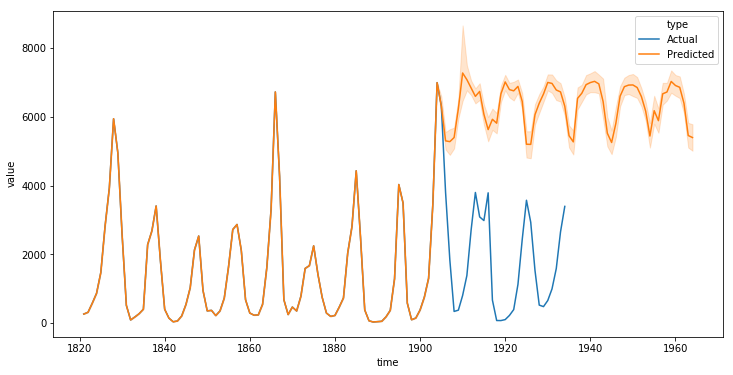

In [374]:
sns.lineplot('time', 'value', data=res3, hue='type');

## Model 1.1: Change prior to smooth non-seasonal component

In [375]:
def model_sgt_2(y, seasonality, predict_ahead=0):
    """
    A bayesian model for Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 10.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.5))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma))

In [376]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_2)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_2, guide, opt, loss=Trace_ELBO())

for i in range(800):
    loss = svi.step(y_train, S)
    print('ELBO loss: {}'.format(loss))

ELBO loss: 1652.212327837944
ELBO loss: 1374.5211765766144
ELBO loss: 1658.4196566343307
ELBO loss: 1565.011170744896
ELBO loss: 5097.7619569301605
ELBO loss: 1535.686631143093
ELBO loss: 885.2283767461777
ELBO loss: 1033.235124528408
ELBO loss: 4396.611421346664
ELBO loss: 1338.1175087094307
ELBO loss: 1925.7938371300697
ELBO loss: 741.2779716849327
ELBO loss: 1199.2045094370842
ELBO loss: 1660.7073771953583
ELBO loss: 2170.2537046670914
ELBO loss: 759.1384881734848
ELBO loss: 748.8081368505955
ELBO loss: 1520.711234331131
ELBO loss: 760.5168852210045
ELBO loss: 1352.5509519577026
ELBO loss: 1018.8502349853516
ELBO loss: 1034.4430500268936
ELBO loss: 1253.2226484417915
ELBO loss: 1988.9284921884537
ELBO loss: 727.8187434077263
ELBO loss: 759.7474061846733
ELBO loss: 971.5908336043358
ELBO loss: 1179.6672594547272
ELBO loss: 801.6704194545746
ELBO loss: 918.2058441638947
ELBO loss: 1273.7778197526932
ELBO loss: 939.5152213573456
ELBO loss: 768.9250081777573
ELBO loss: 944.7309994697571

ELBO loss: 729.5145907402039
ELBO loss: 743.3943967819214
ELBO loss: 727.8655942678452
ELBO loss: 730.9113875627518
ELBO loss: 730.1226474046707
ELBO loss: 727.5316287875175
ELBO loss: 729.1402043700218
ELBO loss: 731.1170138716698
ELBO loss: 727.1132497787476
ELBO loss: 729.6850533485413
ELBO loss: 728.5373040437698
ELBO loss: 730.1329972743988
ELBO loss: 730.2849985361099
ELBO loss: 728.7086894512177
ELBO loss: 732.2043439149857
ELBO loss: 729.0219284892082
ELBO loss: 737.0273187756538
ELBO loss: 732.7275054454803
ELBO loss: 724.3552247881889
ELBO loss: 727.4027738571167
ELBO loss: 727.9857280254364
ELBO loss: 730.8328548669815
ELBO loss: 728.8714005947113
ELBO loss: 727.7727335095406
ELBO loss: 732.9870995283127
ELBO loss: 736.2617743015289
ELBO loss: 734.4413664340973
ELBO loss: 730.0288428068161
ELBO loss: 726.8254568576813
ELBO loss: 726.3217180967331
ELBO loss: 730.4514578580856
ELBO loss: 733.9555550813675
ELBO loss: 731.7445465326309
ELBO loss: 724.573259294033
ELBO loss: 732.

ELBO loss: 730.8982948064804
ELBO loss: 727.4926040172577
ELBO loss: 728.9763361215591
ELBO loss: 729.031550526619
ELBO loss: 728.2443262338638
ELBO loss: 731.3958325386047
ELBO loss: 727.4165461659431
ELBO loss: 728.1576803326607
ELBO loss: 732.1404818296432
ELBO loss: 728.3739489912987
ELBO loss: 729.4858720302582
ELBO loss: 724.3355819582939
ELBO loss: 728.2416010499
ELBO loss: 730.3355178833008
ELBO loss: 734.0667822360992
ELBO loss: 729.0734089612961
ELBO loss: 728.1455504894257
ELBO loss: 728.883126616478
ELBO loss: 724.8924896717072
ELBO loss: 729.4188557267189
ELBO loss: 725.4885287284851
ELBO loss: 732.6984068155289
ELBO loss: 727.2907557487488
ELBO loss: 729.2805379629135
ELBO loss: 724.14632999897
ELBO loss: 729.6501405239105
ELBO loss: 729.5037984848022
ELBO loss: 728.5566491484642
ELBO loss: 728.2576096057892
ELBO loss: 728.5525921583176
ELBO loss: 728.8777070045471
ELBO loss: 729.9700850248337
ELBO loss: 729.6487883329391
ELBO loss: 727.133028447628
ELBO loss: 728.9120110

In [377]:
num_samples = 100
preds, l, s = predict(model_sgt_2, guide, y_train, S, future_steps=60, num_samples=num_samples)

res2 = lynx.copy()
res2['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res2 = res2.append(df, sort=True)
res2 = res2.astype({'time': 'int32'})

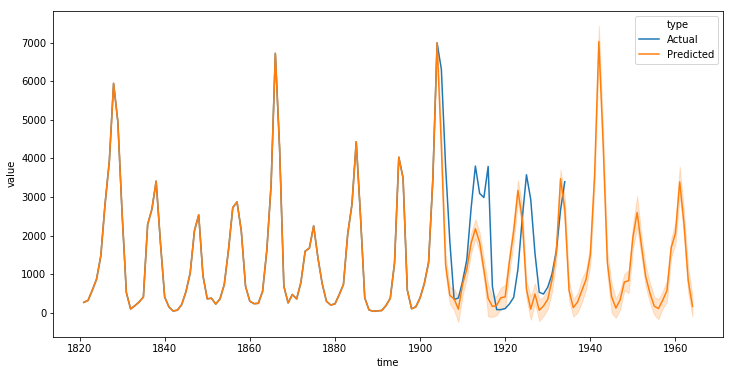

In [378]:
sns.lineplot('time', 'value', data=res2, hue='type');

## Model 2: let the variance also depend on the value of the time series

In [379]:
def model_sgt_3(y, seasonality, predict_ahead=0):
    """
    A bayesian model for Seasonal Global Trend (SGT).
    """
    S = seasonality
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    # NOTE: prior is changed to bias alpha --> 0.
    alpha = pyro.sample('alpha', dist.Beta(1., 10.)) 
    beta = pyro.sample('beta', dist.Beta(1., 1.))
    gamma = pyro.sample('gamma', dist.Beta(1., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Normal(0., 0.1))
    pow_var = pyro.sample('pow_var', dist.Normal(0., 1.))
    s = [torch.tensor(1.)] * len(y)
    l = [torch.tensor(0.)] * len(y)
    l[0] = y[0]
    y_hat = torch.zeros(len(y))
    y_hat[0] = y[0]
    for i in range(1, len(y)):
        seasonality_idx = get_seasonality_lookup_idx(i-1, S, i)
        s_i = s[seasonality_idx]
        assert s[i] > 0
        l[i] = alpha * (y[i] / s_i) + (1 - alpha) * l[i - 1]
        assert l[i] > 0, "alpha: {}".format(alpha)
        s[i] = gamma * (y[i] / l[i]) + (1 - gamma) * s_i
        y_hat[i] = (l[i - 1] + beta * l[i - 1] ** pow_trend) * s_i 
        
    sigma_hat = sigma * y_hat ** pow_var
    pyro.sample('y', dist.StudentT(nu, y_hat, sigma_hat), obs=y)
        
    if predict_ahead > 0:
        y_pred = torch.zeros(predict_ahead)
        for j in range(predict_ahead):
            i = len(y) + j
            s_i = s[get_seasonality_lookup_idx(len(y), S, i)]
            l_i = l[len(y) - 1]
            y_pred[j] = (l_i + j * beta * l_i ** pow_trend) * s_i
        pyro.sample('s', dist.Delta(torch.stack(s)))  # For plotting
        pyro.sample('l', dist.Delta(torch.stack(l)))  # For plotting
        sigma_hat = sigma * y_pred ** pow_var
        pyro.sample('y_pred', dist.StudentT(nu, y_pred, sigma_hat))

In [380]:
pyro.clear_param_store()

S = 38
guide = AutoDiagonalNormal(model_sgt_3)
opt = optim.Adam({'lr': 0.05})
svi = SVI(model_sgt_3, guide, opt, loss=Trace_ELBO())

for i in range(1000):
    loss = svi.step(y_train, S)
    print('ELBO loss: {}'.format(loss))

ELBO loss: 7665.2307035923
ELBO loss: 3066.5547614097595
ELBO loss: 10450.338874340057
ELBO loss: 1480.9714175462723
ELBO loss: 4800.624536454678
ELBO loss: 2062.0396637916565
ELBO loss: 889.0465829372406
ELBO loss: 1204.2610090970993
ELBO loss: 1120.9849754571915
ELBO loss: 10253.123138546944
ELBO loss: 1072.8306840658188
ELBO loss: 818.7565373778343
ELBO loss: 802.6129500865936
ELBO loss: 1091.0965398550034
ELBO loss: 1033.273509502411
ELBO loss: 1471.2719663381577
ELBO loss: 1115.3922226428986
ELBO loss: 1176.463474392891
ELBO loss: 833.5618785619736
ELBO loss: 1113.7521802186966
ELBO loss: 1083.7983914613724
ELBO loss: 1556.147324681282
ELBO loss: 923.0665658712387
ELBO loss: 1091.4373906850815
ELBO loss: 1247.2140192985535
ELBO loss: 1314.6689398288727
ELBO loss: 1322.4939118623734
ELBO loss: 1419.295132637024
ELBO loss: 1286.8235836029053
ELBO loss: 1359.6108870506287
ELBO loss: 852.1352463960648
ELBO loss: 1251.1311124563217
ELBO loss: 1102.521264910698
ELBO loss: 836.1398836374

ELBO loss: 743.4868356585503
ELBO loss: 805.9762636423111
ELBO loss: 776.7739334106445
ELBO loss: 771.6823235750198
ELBO loss: 750.996789932251
ELBO loss: 732.8748008012772
ELBO loss: 832.9809889793396
ELBO loss: 734.8202275037766
ELBO loss: 739.7192718982697
ELBO loss: 765.5413218736649
ELBO loss: 775.0721817016602
ELBO loss: 719.1604931354523
ELBO loss: 831.3713804483414
ELBO loss: 993.870592713356
ELBO loss: 746.0613749027252
ELBO loss: 777.4036648273468
ELBO loss: 785.0997688174248
ELBO loss: 776.2695980072021
ELBO loss: 778.2081010937691
ELBO loss: 789.2111623287201
ELBO loss: 774.0163841247559
ELBO loss: 824.4999542236328
ELBO loss: 758.0920407176018
ELBO loss: 769.5839582681656
ELBO loss: 762.5391941070557
ELBO loss: 718.4733687639236
ELBO loss: 721.8916280269623
ELBO loss: 765.6499464511871
ELBO loss: 767.6046994924545
ELBO loss: 755.7650966644287
ELBO loss: 736.60849994421
ELBO loss: 744.1454111337662
ELBO loss: 760.0710196495056
ELBO loss: 736.169187605381
ELBO loss: 814.6612

ELBO loss: 728.3682532906532
ELBO loss: 732.5084954500198
ELBO loss: 761.90050303936
ELBO loss: 801.2855170965195
ELBO loss: 796.0874435901642
ELBO loss: 752.9208463430405
ELBO loss: 737.5541915297508
ELBO loss: 722.9255321025848
ELBO loss: 726.3839774131775
ELBO loss: 722.6153064966202
ELBO loss: 743.7104964256287
ELBO loss: 784.9941037297249
ELBO loss: 742.5319144129753
ELBO loss: 726.272467136383
ELBO loss: 791.2266877889633
ELBO loss: 743.2697616815567
ELBO loss: 722.9874584674835
ELBO loss: 729.1665169000626
ELBO loss: 732.6458040475845
ELBO loss: 731.9088413119316
ELBO loss: 731.7410121560097
ELBO loss: 733.6303583979607
ELBO loss: 734.027375459671
ELBO loss: 730.4196772575378
ELBO loss: 738.0116182565689
ELBO loss: 734.4324749708176
ELBO loss: 748.5548623800278
ELBO loss: 748.2785880565643
ELBO loss: 744.5802132487297
ELBO loss: 730.3683142066002
ELBO loss: 724.219554066658
ELBO loss: 801.1676986217499
ELBO loss: 804.7480931282043
ELBO loss: 733.4399837851524
ELBO loss: 730.9295

ELBO loss: 714.0033272504807
ELBO loss: 787.9527163505554
ELBO loss: 721.456512093544
ELBO loss: 712.5665543079376
ELBO loss: 722.7632588744164
ELBO loss: 770.7480577230453
ELBO loss: 737.707077383995
ELBO loss: 735.6742311120033
ELBO loss: 737.3446109294891
ELBO loss: 735.3678106069565
ELBO loss: 735.8084205389023
ELBO loss: 764.0745216608047
ELBO loss: 712.3558896780014
ELBO loss: 721.006269454956
ELBO loss: 710.3889910578728
ELBO loss: 720.6561269760132
ELBO loss: 750.1320028305054
ELBO loss: 723.4859254360199
ELBO loss: 727.4041189551353
ELBO loss: 736.8220249414444
ELBO loss: 736.371604681015
ELBO loss: 730.3280330896378
ELBO loss: 725.8246853351593
ELBO loss: 750.4786796569824
ELBO loss: 726.6656235456467
ELBO loss: 732.9923743605614
ELBO loss: 736.0278912186623
ELBO loss: 753.3438540101051
ELBO loss: 745.6080067753792
ELBO loss: 743.3144386410713
ELBO loss: 734.1217501759529
ELBO loss: 733.4497585296631
ELBO loss: 722.7147626876831
ELBO loss: 720.7488878369331
ELBO loss: 733.311

In [381]:
num_samples = 100
preds, l, s = predict(model_sgt_3, guide, y_train, S, future_steps=60, num_samples=num_samples)

res4 = lynx.copy()
res4['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res4 = res4.append(df, sort=True)
res4 = res4.astype({'time': 'int32'})

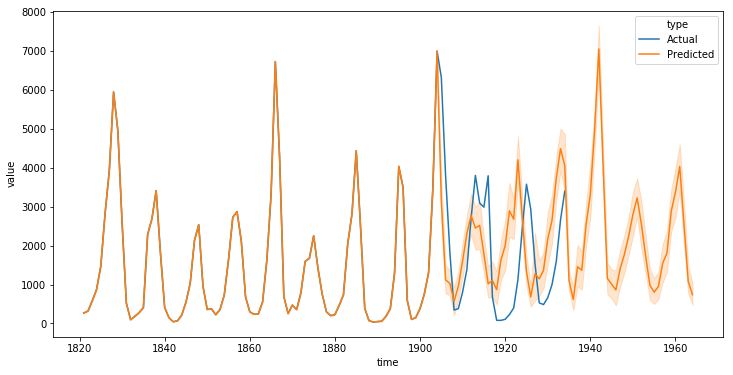

In [382]:
sns.lineplot('time', 'value', data=res4, hue='type');

## Exact inference using MCMC

In [383]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

In [384]:
model = model_sgt_2  # compiling model_sgt_3 takes too long
nuts_kernel = NUTS(model=model, jit_compile=True, ignore_jit_warnings=True)
num_samples = 1000
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_samples)
S = 38
mcmc.run(y_train, S)

sample: 100%|██████████| 2000/2000 [00:39<00:00, 50.04it/s, step size=4.73e-01, acc. prob=0.883]


In [385]:
def predict_mcmc(model, model_samples, y, *args, future_steps=30):
    """
    Generate `num_samples` predictions by sampling the parameters for the
    time series model from the approximate posterior.    
    """
    preds = []
    l, s = [], []
    for i in range(len(model_samples)):
        model_trace = poutine.trace(poutine.condition(model, model_samples)).get_trace(y, *args, 
                                                                                       predict_ahead=future_steps)
        preds.append(torch.cat([model_trace.nodes['y']['value'], model_trace.nodes['y_pred']['value']]))
        l.append(model_trace.nodes['l']['value'])
        s.append(model_trace.nodes['s']['value'])
    return torch.stack(preds), torch.stack(l), torch.stack(s)

In [386]:
samples = mcmc.get_samples()
samples_list = [{k: v[i] for k, v in samples.items()} for i in range(num_samples)]
preds, l, s = predict_mcmc(model, samples_list, y_train, S, future_steps=60)

res5 = lynx.copy()
res5['type'] = 'Actual'
l_samples = np.hstack([l.detach().cpu().numpy(), 
                      np.full((num_samples, len(preds[1]) - len(l[1])), np.nan)
                      ]).flatten()
s_samples = np.hstack([s.detach().cpu().numpy(), 
                       np.full((num_samples, len(preds[1]) - len(s[1])), np.nan)
                      ]).flatten()
df = pd.DataFrame(np.stack([
    np.tile(np.arange(1821, 1821 + len(preds[1])), num_samples), 
    preds.flatten().detach().cpu().numpy(),
    l_samples,
    s_samples,
]).T, columns=['time', 'value', 'l', 's'])
df['type'] = 'Predicted'
res5 = res5.append(df, sort=True)
res5 = res5.astype({'time': 'int32'})

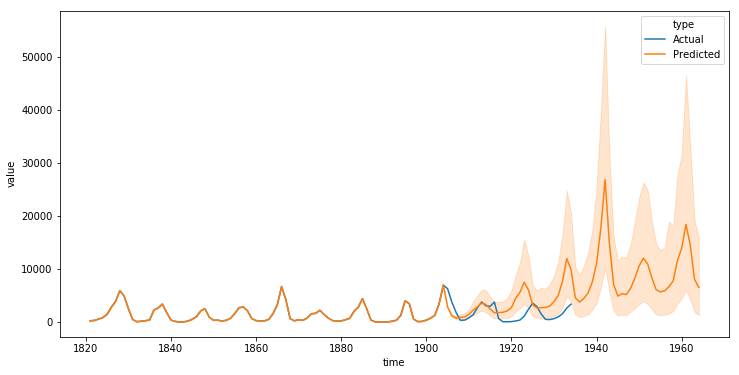

In [387]:
sns.lineplot('time', 'value', data=res5, hue='type');